In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


 **Step1: Identifying the problem**

- <b>Objective: </b>In this challenge, we have a list of users along with information of their activity on website such as date of account created, time when user first active on the website, the country for which user has done booking etc. We also got have some personal information about each user. Our task is to build a machine learning model which will predict which country a new user's first booking destination will be.


- <b>Data: </b>Following are the features present in training dataset:
    - id: user id
    - date_account_created: the date of account creation
    - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    - date_first_booking: date of first booking
    - gender
    - age
    - signup_method: whether user has signup from website or by using facebook, gmail etc.
    - signup_flow: the page a user came to signup up from
    - language: international language preference
    - affiliate_channel: what kind of paid marketing
    - affiliate_provider: where the marketing is e.g. google, craigslist, other
    - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    - signup_app
    - first_device_type
    - first_browser
    - country_destination: this is the target variable. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. 
    <br>Note: 
        - 'other' means there was a booking, but is to a country not included in the list
        - 'NDF' means there wasn't destination found = no booking.


- There other 3 files given along with train and test dataset.
    1. sessions.csv - this file contain all web sessions log for each user
    2. countries.csv - summary statistics of destination countries in this dataset and their locations
    3. age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

Reading the data given

In [2]:
train = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip")
test = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip")
countries=pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip')
sample=pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip')

**Step 2: Data Exploration**

In [3]:
test.head()
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [6]:
countries.describe()

,lat_destination,lng_destination,distance_km,destination_km2,language_levenshtein_distance
count,10.000000,10.000000,10.000000,1.000000e+01,10.00000
mean,39.799398,-4.262446,7181.897800,2.973734e+06,50.49900
std,24.739112,63.700585,3941.141734,4.329619e+06,44.54169
min,-26.853388,-96.818146,0.000000,4.154300e+04,0.00000
25%,39.639090,-6.737559,7001.557600,2.580425e+05,0.00000
50%,44.053092,-0.139014,7603.632650,4.311960e+05,67.91500
75%,51.891219,9.163386,7842.357000,5.966865e+06,91.39500
max,62.393303,133.275160,15297.744000,9.984670e+06,95.45000


In [7]:
countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [8]:
sample.describe()

,id,country
count,62096,62096
unique,62096,1
top,5uwns89zht,NDF
freq,1,62096


In [9]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       62096 non-null  object
 1   country  62096 non-null  object
dtypes: object(2)
memory usage: 970.4+ KB


In [10]:
print (pd.value_counts(train['country_destination'].values))

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
dtype: int64


In [11]:
print (pd.value_counts(train['gender'].values))

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
dtype: int64


In [12]:
print (pd.value_counts(train['language'].values))

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
dtype: int64


**some data cleaning**

In [13]:
train["date_account_created"] = pd.to_datetime( train["date_account_created"])
train["date_first_booking"] = pd.to_datetime( train["date_first_booking"])
train["timestamp_first_active"] = pd.to_datetime(train["timestamp_first_active"], format="%Y%m%d%H%M%S")
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


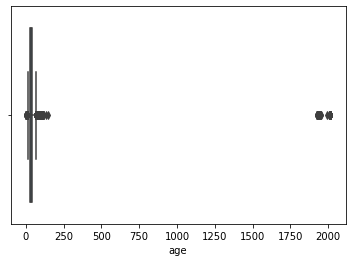

In [14]:
ax = sns.boxplot(x=train["age"])

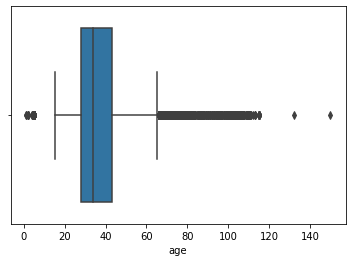

In [15]:
train = train[np.abs(train['age']- train ['age'].mean()) <= (3*train['age'].std())]
ax = sns.boxplot(x=train["age"])

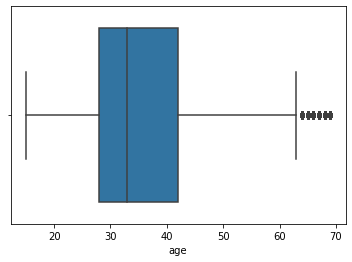

In [16]:
index = train[(train['age'] >= 70)|(train['age'] <= 5)].index
train.drop(index, inplace=True)
Mean_age = train['age'].mean()
train['age'] = train['age'].fillna(Mean_age)
ax = sns.boxplot(x=train["age"])

**Data visualiztaion**

see if gender have a good relation with sign up method used

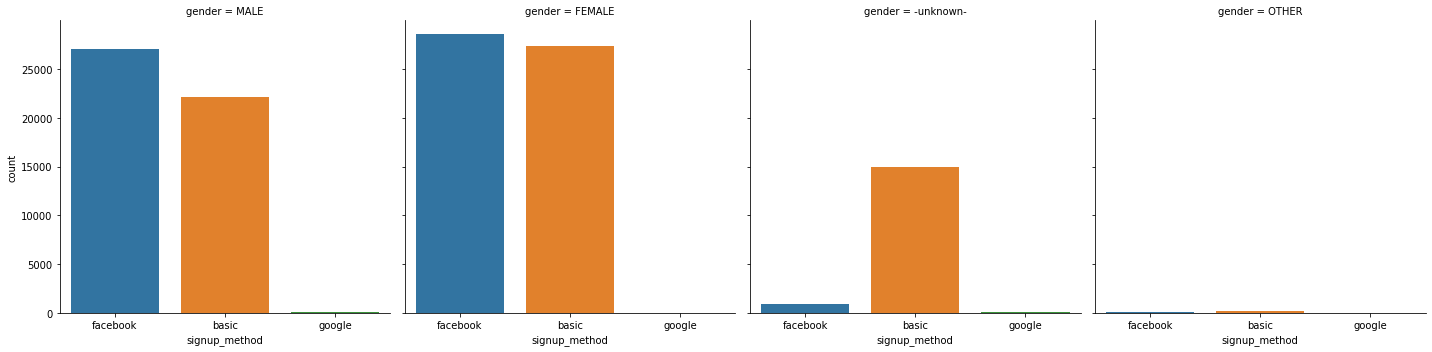

In [17]:
sns.catplot(x='signup_method', col='gender', kind='count', data=train);

Text(0, 0.5, 'Frequency')

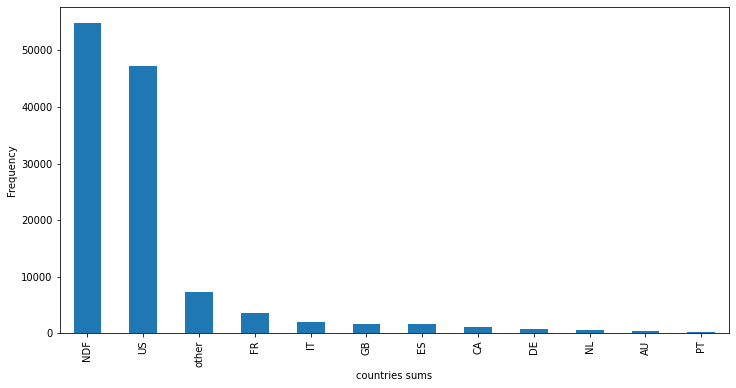

In [18]:
plt.figure(figsize=(12, 6))
train['country_destination'].value_counts().plot(kind='bar')
plt.xlabel('countries sums')
plt.ylabel('Frequency')

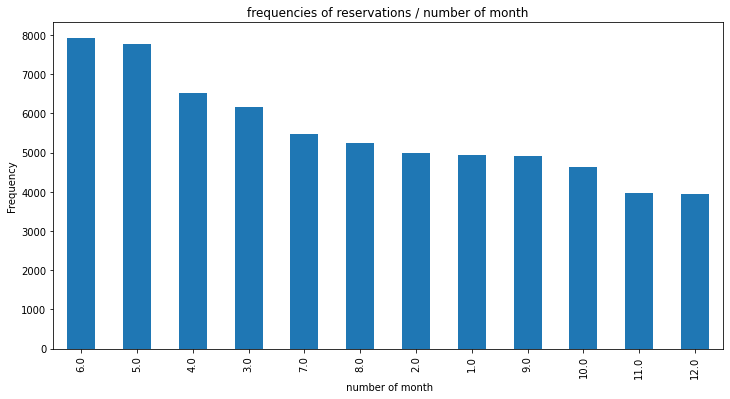

In [19]:
train['month'] = train['date_first_booking'].dt.month
plt.figure(figsize=(12, 6))
train['month'].value_counts().plot(kind='bar')
plt.title('frequencies of reservations / number of month')
plt.xlabel(' number of month')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

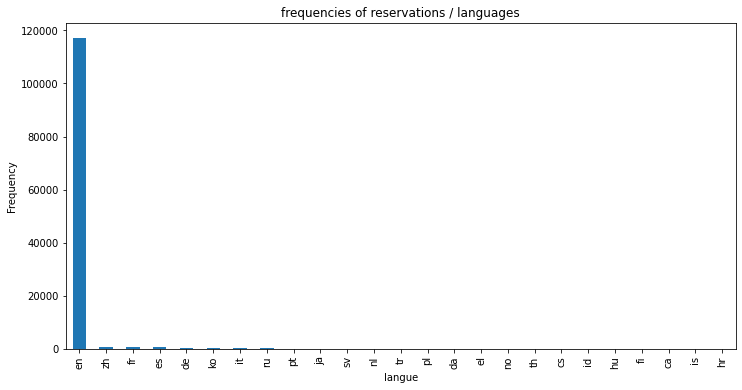

In [20]:
plt.figure(figsize=(12, 6))
train['language'].value_counts().plot(kind='bar')
plt.title('frequencies of reservations / languages')
plt.xlabel('langue')
plt.ylabel('Frequency')

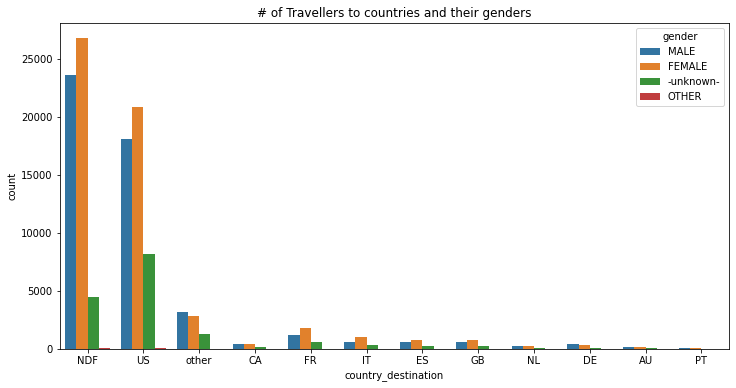

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='gender', data=train)
plt.title('# of Travellers to countries and their genders')
plt.show()

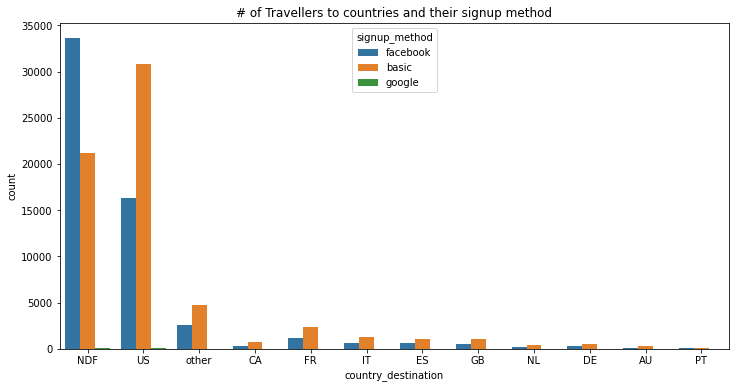

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='signup_method', data=train)
plt.title('# of Travellers to countries and their signup method')
plt.show()

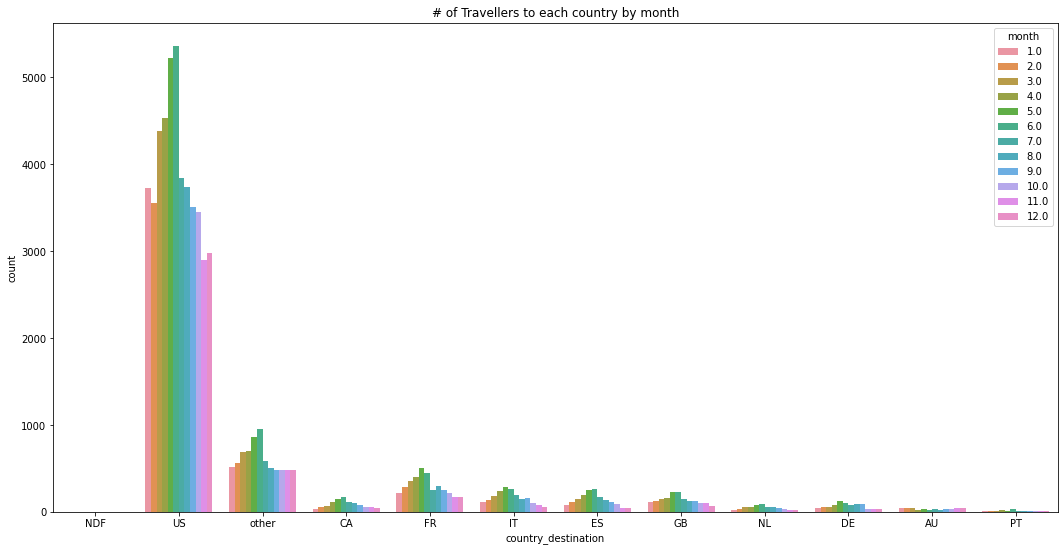

In [23]:
plt.figure(figsize=(18, 9))
sns.countplot(x='country_destination', hue='month', data=train)
plt.title('# of Travellers to each country by month')
plt.show()

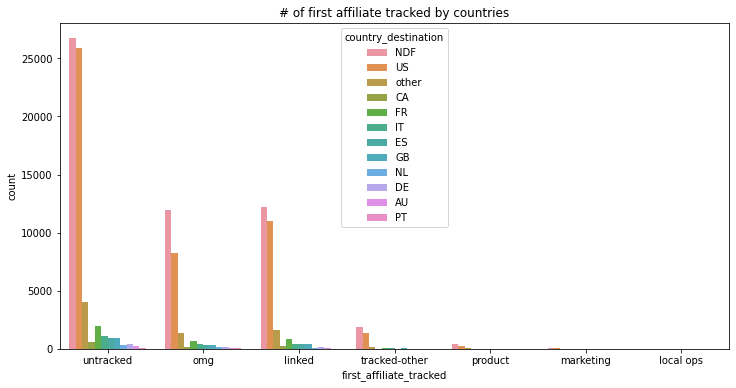

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(x='first_affiliate_tracked',data=train,hue='country_destination')
plt.title('# of first affiliate tracked by countries')
plt.show()

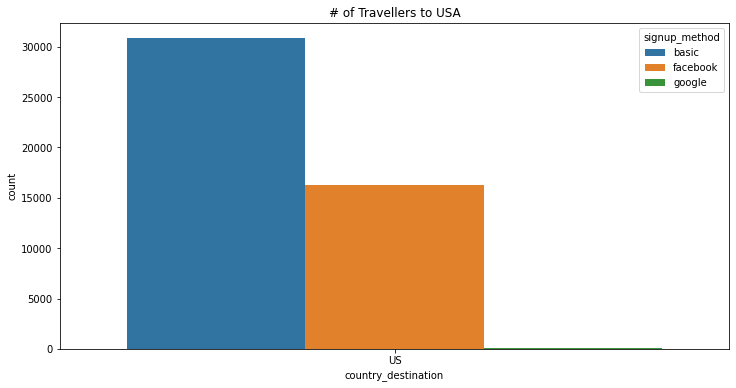

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='signup_method', data=train[train['country_destination']=='US'])
plt.title('# of Travellers to USA')
plt.show()

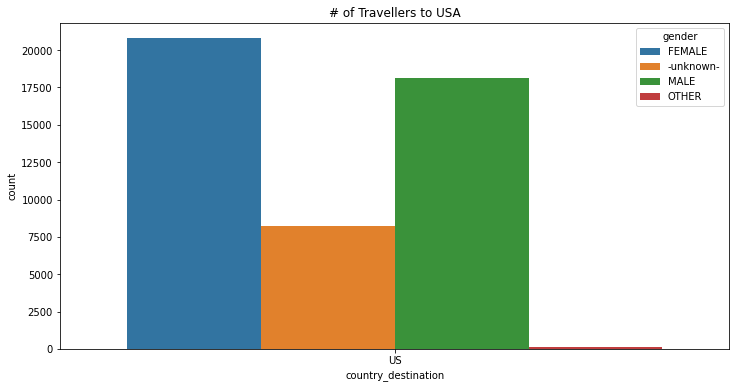

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='gender', data=train[train['country_destination']=='US'])
plt.title('# of Travellers to USA')
plt.show()

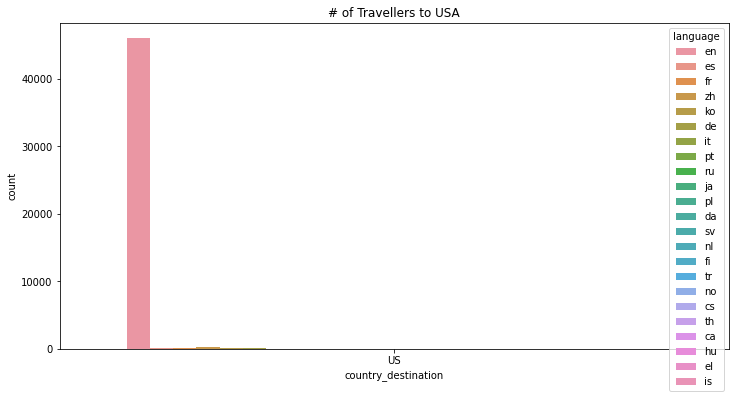

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='language', data=train[train['country_destination']=='US'])
plt.title('# of Travellers to USA')
plt.show()

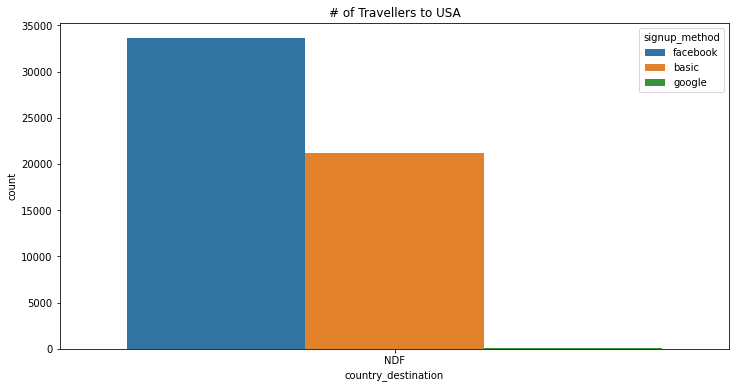

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='signup_method', data=train[train['country_destination']=='NDF'])
plt.title('# of Travellers to USA')
plt.show()

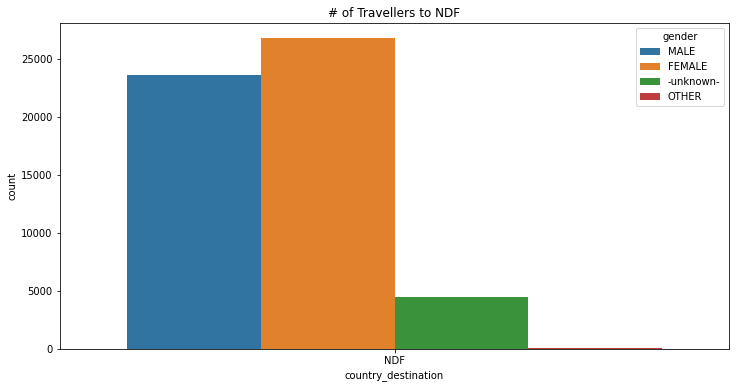

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='gender', data=train[train['country_destination']=='NDF'])
plt.title('# of Travellers to NDF')
plt.show()

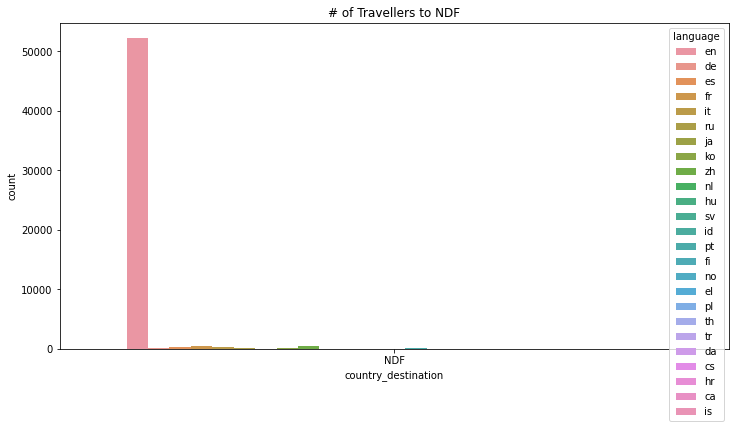

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country_destination', hue='language', data=train[train['country_destination']=='NDF'])
plt.title('# of Travellers to NDF')
plt.show()

**Preprocessing**

In [31]:
sex = {'MALE': 0,'FEMALE': 1, 'OTHER': 2, '-unknown-':3}
train.gender = [sex[item] for item in train.gender]
test.gender = [sex[item] for item in test.gender]

train.drop(['id','date_first_booking', 'date_account_created', 'timestamp_first_active','signup_app', 'first_device_type', 'first_browser', 'first_affiliate_tracked', 'signup_flow'],axis=1,inplace=True)
test.drop(['id','date_first_booking', 'date_account_created',  'timestamp_first_active','signup_app', 'first_device_type', 'first_browser', 'first_affiliate_tracked'],axis=1,inplace=True)

print(train)

        gender   age signup_method language affiliate_channel  \
1            0  38.0      facebook       en               seo   
2            1  56.0         basic       en            direct   
3            1  42.0      facebook       en            direct   
4            3  41.0         basic       en            direct   
6            1  46.0         basic       en             other   
...        ...   ...           ...      ...               ...   
213441       1  34.0         basic       en            direct   
213443       1  36.0         basic       en         sem-brand   
213445       1  23.0         basic       en         sem-brand   
213446       0  32.0         basic       en         sem-brand   
213448       3  32.0         basic       en            direct   

       affiliate_provider country_destination  month  
1                  google                 NDF    NaN  
2                  direct                  US    8.0  
3                  direct               other    9.0  

**the features that will help the model**

In [32]:
Features = ['gender', 'language','signup_method','affiliate_channel','month', 'age']

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

lable encoder to transform string data into numerical

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train[Features] = train[Features].apply(lambda col: le.fit_transform(col))

In [35]:
train.head()

,gender,age,signup_method,language,affiliate_channel,affiliate_provider,country_destination,month
1,0,23,1,5,7,google,NDF,17154
2,1,41,0,5,2,direct,US,7
3,1,27,1,5,2,direct,other,8
4,3,26,0,5,2,direct,US,1
6,1,31,0,5,3,craigslist,US,0


In [36]:
x=train[Features]
y=train['country_destination']

**downsampling**

In [37]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = train[train.country_destination=='NDF']
df_minority = train[train.country_destination=='US']

 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=49,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
train = pd.concat([df_majority_downsampled, df_minority])
 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47254 entries, 212142 to 213445
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               47254 non-null  int64 
 1   age                  47254 non-null  int64 
 2   signup_method        47254 non-null  int64 
 3   language             47254 non-null  int64 
 4   affiliate_channel    47254 non-null  int64 
 5   affiliate_provider   47254 non-null  object
 6   country_destination  47254 non-null  object
 7   month                47254 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 3.2+ MB


**spliting train data into test and train data**

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

**inserting random forest**

In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

**Applying Random Forest and calculating score**

In [40]:
rfc.fit(x_train,y_train)
Y_pred =rfc.predict(x_test)
score = rfc.score(x_test, y_test)
print(score*100)

82.01395374388837
